In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from plotly.subplots import make_subplots
from scipy.stats import t
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
station = "Hot"
time_start = "2002-01-01"
time_end = "2015-01-01"

## Load


In [3]:
data = xr.load_dataset(f"./products/{station}_obs_filtered.zarr", engine="zarr")
data

<xarray.Dataset> Size: 12kB
Dimensions:    (time: 514, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 4kB 1994-02-17 1994-02-18 ... 2022-09-01
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB 0.4208 ... 2.282
    night      (time, latitude, longitude, layer) float64 4kB 1.48 ... 2.425
Attributes:
    creation date:  2024-10-13T20:03:40.309826
    layer:          epipelagic
    station:        Hot

In [4]:
fig = go.Figure()

# Plot day data
fig.add_trace(
    go.Scatter(
        x=data.day.dropna("time").time.data.flatten(),
        y=data.day.dropna("time").data.flatten(),
        mode="lines",
        name="Day",
    )
)

# Plot night data
fig.add_trace(
    go.Scatter(
        x=data.night.dropna("time").time.data.flatten(),
        y=data.night.dropna("time").data.flatten(),
        mode="lines",
        name="Night",
    )
)

# Add vertical lines for 2000 and 2015
fig.add_shape(
    type="line",
    x0=time_start,
    y0=0,
    x1=time_start,
    y1=1,
    xref="x",
    yref="paper",
    line=dict(color="black", width=2, dash="dash"),
    name="Year 2000",
)

fig.add_shape(
    type="line",
    x0=time_end,
    y0=0,
    x1=time_end,
    y1=1,
    xref="x",
    yref="paper",
    line=dict(color="black", width=2, dash="dash"),
    name="Year 2015",
)

# Update layout
fig.update_layout(
    title=f"Day and Night Data at {station} : remove interannual variability",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
    legend_title="Legend",
    height=600,
    width=800,
    showlegend=True,
)

fig.show()

In [5]:
data = data.sel(time=slice(time_start, time_end))
data

<xarray.Dataset> Size: 6kB
Dimensions:    (time: 237, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 2kB 2002-01-15 2002-01-16 ... 2014-12-17
Data variables:
    day        (time, latitude, longitude, layer) float64 2kB 1.033 ... 1.935
    night      (time, latitude, longitude, layer) float64 2kB 2.419 ... 1.971
Attributes:
    creation date:  2024-10-13T20:03:40.309826
    layer:          epipelagic
    station:        Hot

## Number of samples


In [6]:
# Calculer les comptes mensuels
day_counts_month = data.groupby("time.month").count().day[:, 0, 0, 0]
night_counts_month = data.groupby("time.month").count().night[:, 0, 0, 0]

day_counts_month_cumsum = day_counts_month.cumsum()
night_counts_month_cumsum = night_counts_month.cumsum()

# Calculer les comptes annuels
day_counts_year = data.groupby("time.year").count().day[:, 0, 0, 0]
night_counts_year = data.groupby("time.year").count().night[:, 0, 0, 0]

day_counts_year_cumsum = day_counts_year.cumsum()
night_counts_year_cumsum = night_counts_year.cumsum()

# Créer la figure avec des subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Yearly Data", "Monthly Data"))

# Ajouter les traces pour les données annuelles
fig.add_trace(go.Scatter(x=day_counts_year["year"], y=day_counts_year, mode="lines+markers", name="Day"), row=1, col=1)
fig.add_trace(
    go.Scatter(x=night_counts_year["year"], y=night_counts_year, mode="lines+markers", name="Night"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=day_counts_year_cumsum["year"],
        y=day_counts_year_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_year_cumsum["year"],
        y=night_counts_year_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=1,
)

# Ajouter les traces pour les données mensuelles
fig.add_trace(
    go.Scatter(x=day_counts_month["month"], y=day_counts_month, mode="lines+markers", name="Day"), row=1, col=2
)
fig.add_trace(
    go.Scatter(x=night_counts_month["month"], y=night_counts_month, mode="lines+markers", name="Night"), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=day_counts_month_cumsum["month"],
        y=day_counts_month_cumsum,
        mode="lines+markers",
        name="Day Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=night_counts_month_cumsum["month"],
        y=night_counts_month_cumsum,
        mode="lines+markers",
        name="Night Cumulative",
        visible=False,
    ),
    row=1,
    col=2,
)

# Mettre à jour la mise en page avec le menu déroulant
fig.update_layout(
    title=f"Nb of samples during day and night by year and month at {station}",
    xaxis_title="Year",
    yaxis_title="Nb of samples",
    legend_title="Legend",
    xaxis={"showgrid": True},
    yaxis={"showgrid": True},
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [{"visible": [True, True, False, False, True, True, False, False]}],
                    "label": "Non-Cumulative",
                    "method": "update",
                },
                {
                    "args": [{"visible": [False, False, True, True, False, False, True, True]}],
                    "label": "Cumulative",
                    "method": "update",
                },
            ],
            "direction": "down",
            "showactive": True,
        }
    ],
)
# wider layout
fig.update_layout(width=1100, height=600)
fig.show()

## Computing the trend


/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_7945/70799619.py:6: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

/var/folders/z_/8j3qx1mn0299kkpjgz9g53780000gq/T/ipykernel_7945/70799619.py:13: UserWarning:

Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be s

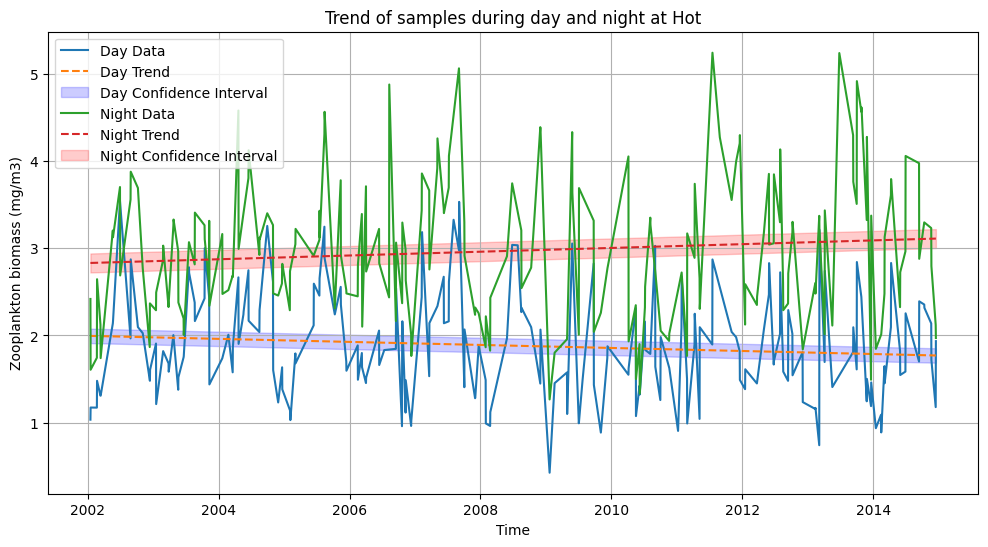

In [7]:
# Extraire les données de jour et de nuit
day_data = data["day"][:, 0, 0, 0].dropna(dim="time")
night_data = data["night"][:, 0, 0, 0].dropna(dim="time")

# Extraire les indices de temps en jours
time_indices = (day_data["time"] - day_data["time"][0]).astype("timedelta64[D]").astype(int)

# Ajuster une ligne droite aux données de jour
day_trend = np.polyfit(time_indices, day_data, 1)
day_trend_line = np.polyval(day_trend, time_indices)

# Ajuster une ligne droite aux données de nuit
night_time_indices = (night_data["time"] - night_data["time"][0]).astype("timedelta64[D]").astype(int)
night_trend = np.polyfit(night_time_indices, night_data, 1)
night_trend_line = np.polyval(night_trend, night_time_indices)

# Calculer l'erreur standard des tendances de jour et de nuit
day_std_error = np.std(day_data - day_trend_line) / np.sqrt(len(day_data))
night_std_error = np.std(night_data - night_trend_line) / np.sqrt(len(night_data))

# Définir le niveau de confiance (par exemple, 95%)
confidence_level = 0.95
degrees_freedom_day = len(day_data) - 2
degrees_freedom_night = len(night_data) - 2

# Calculer la valeur critique t pour le niveau de confiance et les degrés de liberté
t_critical_day = t.ppf((1 + confidence_level) / 2, degrees_freedom_day)
t_critical_night = t.ppf((1 + confidence_level) / 2, degrees_freedom_night)

# Calculer l'intervalle de confiance
day_confidence_interval = float(t_critical_day * day_std_error)
night_confidence_interval = float(t_critical_night * night_std_error)

# Tracer les données et les intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_trend_line, label="Day Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_trend_line - day_confidence_interval,
    day_trend_line + day_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_trend_line, label="Night Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_trend_line - night_confidence_interval,
    night_trend_line + night_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Confidence Interval",
)

plt.legend()
plt.title(f"Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

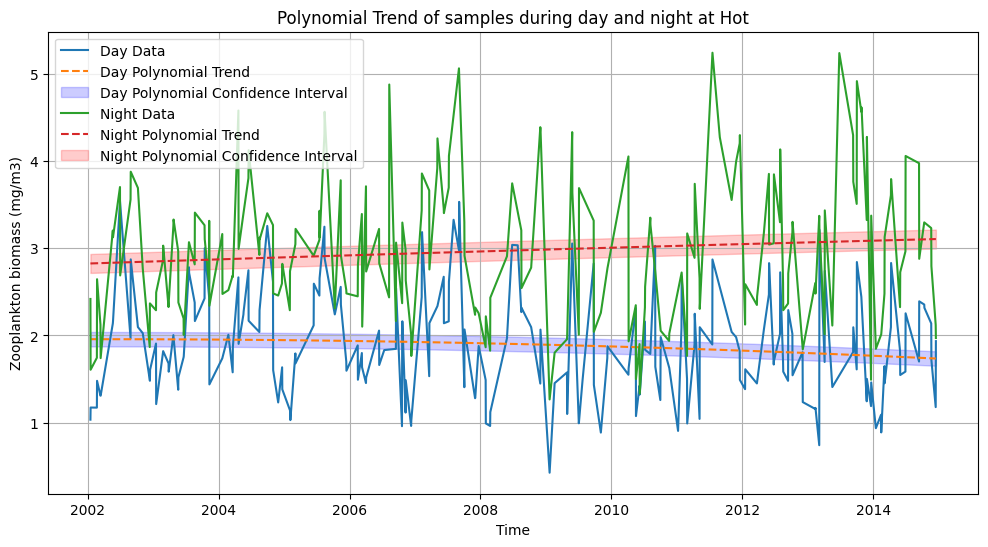

In [8]:
# Ajuster une fonction polynomiale de degré 2 aux données de jour
day_poly_trend = np.polyfit(time_indices, day_data, 2)
day_poly_trend_line = np.polyval(day_poly_trend, time_indices)

# Ajuster une fonction polynomiale de degré 2 aux données de nuit
night_poly_trend = np.polyfit(night_time_indices, night_data, 2)
night_poly_trend_line = np.polyval(night_poly_trend, night_time_indices)

# Calculer l'erreur standard des tendances polynomiales de jour et de nuit
day_poly_std_error = np.std(day_data - day_poly_trend_line) / np.sqrt(len(day_data))
night_poly_std_error = np.std(night_data - night_poly_trend_line) / np.sqrt(len(night_data))

# Calculer l'intervalle de confiance pour les tendances polynomiales
day_poly_confidence_interval = float(t_critical_day * day_poly_std_error)
night_poly_confidence_interval = float(t_critical_night * night_poly_std_error)

# Tracer les données et les intervalles de confiance pour les tendances polynomiales
plt.figure(figsize=(12, 6))
plt.plot(day_data["time"], day_data, label="Day Data")
plt.plot(day_data["time"], day_poly_trend_line, label="Day Polynomial Trend", linestyle="--")
plt.fill_between(
    day_data["time"],
    day_poly_trend_line - day_poly_confidence_interval,
    day_poly_trend_line + day_poly_confidence_interval,
    color="b",
    alpha=0.2,
    label="Day Polynomial Confidence Interval",
)

plt.plot(night_data["time"], night_data, label="Night Data")
plt.plot(night_data["time"], night_poly_trend_line, label="Night Polynomial Trend", linestyle="--")
plt.fill_between(
    night_data["time"],
    night_poly_trend_line - night_poly_confidence_interval,
    night_poly_trend_line + night_poly_confidence_interval,
    color="r",
    alpha=0.2,
    label="Night Polynomial Confidence Interval",
)

plt.legend()
plt.title(f"Polynomial Trend of samples during day and night at {station}")
plt.xlabel("Time")
plt.ylabel("Zooplankton biomass (mg/m3)")
plt.grid()
plt.show()

## Group data by month


In [9]:
grouped_data = xr.Dataset({"day": data.day, "night": data.night})

# Calculer les moyennes mensuelles des données détrendées
grouped_data = grouped_data.groupby("time.month").mean()
grouped_data

# ajouter des nan pour les semaines manquantes
grouped_data = grouped_data.reindex(month=np.arange(1, 13))
grouped_data

<xarray.Dataset> Size: 312B
Dimensions:    (month: 12, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    day        (month, latitude, longitude, layer) float64 96B 1.397 ... 1.528
    night      (month, latitude, longitude, layer) float64 96B 2.237 ... 2.595

## Raw data, no smoothing


In [10]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=grouped_data.day.dropna("month").month.data.flatten(),
        y=grouped_data.day.dropna("month").data.flatten(),
        mode="lines",
        name="day",
    )
)

fig.add_trace(
    go.Scatter(
        x=grouped_data.night.dropna("month").month.data.flatten(),
        y=grouped_data.night.dropna("month").data.flatten(),
        mode="lines",
        name="night",
    )
)

fig.update_layout(
    title=f"Climatology of samples during day and night at {station}",
    xaxis_title="Month of year",
    yaxis_title="Zooplankton biomass (mg/m3)",
    legend_title="Legend",
    height=600,
    width=800,
    showlegend=True,
)

fig.show()

In [11]:
grouped_data_less = grouped_data.assign_coords(month=grouped_data.month - 12)
grouped_data_more = grouped_data.assign_coords(month=grouped_data.month + 12)

gathered_data = xr.concat([grouped_data_less, grouped_data, grouped_data_more], dim="month")
gathered_data

<xarray.Dataset> Size: 888B
Dimensions:    (month: 36, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * layer      (layer) int64 8B 0
  * longitude  (longitude) int64 8B -158
  * month      (month) int64 288B -11 -10 -9 -8 -7 -6 -5 ... 19 20 21 22 23 24
Data variables:
    day        (month, latitude, longitude, layer) float64 288B 1.397 ... 1.528
    night      (month, latitude, longitude, layer) float64 288B 2.237 ... 2.595

## Smooth


In [12]:
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=("Day", "Night"),
    vertical_spacing=0.1,
    x_title="month of year",
    y_title="Zooplankton biomass (mg/m3)",
)
fig.add_trace(
    go.Scatter(x=gathered_data.month.data.flatten(), y=gathered_data.day.data.flatten(), mode="lines", name="day"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=gathered_data.month.data.flatten(), y=gathered_data.night.data.flatten(), mode="lines", name="night"),
    row=2,
    col=1,
)
for frac in [0.15]:
    lowess_day = lowess(gathered_data.day.data.flatten(), gathered_data.month.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_day[:, 0], y=lowess_day[:, 1], mode="lines", name=f"day lowess {frac}"),
        row=1,
        col=1,
    )

    lowess_night = lowess(gathered_data.night.data.flatten(), gathered_data.month.data.flatten(), frac=frac)
    fig.add_trace(
        go.Scatter(x=lowess_night[:, 0], y=lowess_night[:, 1], mode="lines", name=f"night lowess {frac}"),
        row=2,
        col=1,
    )
    gathered_data[f"day_lowess_{frac}"] = xr.DataArray(
        lowess_day[:, 1],
        dims=["month"],
        coords={"month": lowess_day[:, 0]},
        attrs={"frac": frac, "units": "mg/m3"},
    )
    gathered_data[f"night_lowess_{frac}"] = xr.DataArray(
        lowess_night[:, 1],
        dims=["month"],
        coords={"month": lowess_night[:, 0]},
        attrs={"frac": frac, "units": "mg/m3"},
    )

fig.update_layout(
    title=f"Day and night zooplankton observations at {station}",
    height=800,
)

fig.show()

In [13]:
gathered_data = gathered_data.sel(month=slice(1, 12))
gathered_data

<xarray.Dataset> Size: 504B
Dimensions:            (month: 12, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude           (latitude) float64 8B 22.75
  * layer              (layer) int64 8B 0
  * longitude          (longitude) int64 8B -158
  * month              (month) float64 96B 1.0 2.0 3.0 4.0 ... 10.0 11.0 12.0
Data variables:
    day                (month, latitude, longitude, layer) float64 96B 1.397 ...
    night              (month, latitude, longitude, layer) float64 96B 2.237 ...
    day_lowess_0.15    (month) float64 96B 1.465 1.506 1.686 ... 1.76 1.543
    night_lowess_0.15  (month) float64 96B 2.538 2.533 2.785 ... 2.977 2.605

## Duplicating observation across the entire time period


In [14]:
value_by_month = (
    gathered_data.to_dataframe().reset_index().drop(columns=["latitude", "longitude", "layer"]).set_index("month")
)
value_by_month.head()

,day,night,day_lowess_0.15,night_lowess_0.15
month,,,,
1.0,1.397412,2.237120,1.465452,2.537538
2.0,1.472632,2.551672,1.505718,2.533098
3.0,1.671131,2.727920,1.686339,2.785320
4.0,1.927001,3.127462,1.872311,2.956533
5.0,2.010804,3.024495,2.007825,3.073315


In [26]:
time = pd.date_range(start=data.indexes["time"][0], end=data.indexes["time"][-1], freq="ME")
month = time.month
month_by_day = pd.DataFrame({"month": month}, index=time)
month_by_day.head()

,month
2002-01-31,1
2002-02-28,2
2002-03-31,3
2002-04-30,4
2002-05-31,5


In [27]:
aggregated_smoothed = month_by_day.join(value_by_month, on="month").drop(columns=["month"])
aggregated_smoothed.index.name = "time"
aggregated_smoothed

,day,night,day_lowess_0.15,night_lowess_0.15
time,,,,
2002-01-31,1.397412,2.237120,1.465452,2.537538
2002-02-28,1.472632,2.551672,1.505718,2.533098
2002-03-31,1.671131,2.727920,1.686339,2.785320
2002-04-30,1.927001,3.127462,1.872311,2.956533
2002-05-31,2.010804,3.024495,2.007825,3.073315
...,...,...,...,...
2014-07-31,2.195116,3.414854,2.205645,3.307712
2014-08-31,2.345083,3.364356,2.303387,3.337321
2014-09-30,2.323319,3.214469,2.227385,3.274465


In [28]:
climato_observations = xr.Dataset.from_dataframe(aggregated_smoothed)
for var in climato_observations:
    climato_observations[var].attrs = {"units": "mg/m3"}
climato_observations.attrs = {
    "desc": "Aggregated and smoothed observations using lowess filtre.",
}
climato_observations

<xarray.Dataset> Size: 6kB
Dimensions:            (time: 155)
Coordinates:
  * time               (time) datetime64[ns] 1kB 2002-01-31 ... 2014-11-30
Data variables:
    day                (time) float64 1kB 1.397 1.473 1.671 ... 2.044 1.719
    night              (time) float64 1kB 2.237 2.552 2.728 ... 3.276 3.031
    day_lowess_0.15    (time) float64 1kB 1.465 1.506 1.686 ... 2.227 2.034 1.76
    night_lowess_0.15  (time) float64 1kB 2.538 2.533 2.785 ... 3.185 2.977
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

## Plot final results


In [31]:
day_names = ["day", "day_lowess_0.15"]
night_names = ["night", "night_lowess_0.15"]

fig = make_subplots(
    rows=2,
    cols=1,
    subplot_titles=("Day Data", "Night Data"),
    shared_xaxes=True,
    vertical_spacing=0.1,
)
# augmente la taille de la figure
fig.update_layout(height=800)

# -------------------------------------------------------------------------------------------------------------------- #

# Ajouter les données d'observation initiales de jour
fig.add_trace(
    go.Scatter(
        x=day_data["time"],
        y=day_data,
        mode="lines",
        name="Initial Day Data",
    ),
    row=1,
    col=1,
)

# Ajouter les données d'observation initiales de nuit
fig.add_trace(
    go.Scatter(
        x=night_data["time"],
        y=night_data,
        mode="lines",
        name="Initial Night Data",
    ),
    row=2,
    col=1,
)

# -------------------------------------------------------------------------------------------------------------------- #

for day, night in zip(day_names, night_names):
    # Ajouter les données de jour
    fig.add_trace(
        go.Scatter(
            x=aggregated_smoothed.index,
            y=aggregated_smoothed[day],
            mode="lines",
            name=day,
        ),
        row=1,
        col=1,
    )

    # Ajouter les données de nuit
    fig.add_trace(
        go.Scatter(
            x=aggregated_smoothed.index,
            y=aggregated_smoothed[night],
            mode="lines",
            name=night,
        ),
        row=2,
        col=1,
    )

# -------------------------------------------------------------------------------------------------------------------- #

# Mettre à jour la mise en page
fig.update_layout(
    title=f"Comparison of Initial and Processed Data at {station} : With Trend",
    xaxis_title="Time",
    yaxis_title="Zooplankton biomass (mg/m3)",
    # night mode
    # template="plotly_dark",
)

fig.show()

In [17]:
# fig.write_html(f"Hot_climato_observations_filtered.html")

## Export


In [32]:
climato_observations

<xarray.Dataset> Size: 6kB
Dimensions:            (time: 155)
Coordinates:
  * time               (time) datetime64[ns] 1kB 2002-01-31 ... 2014-11-30
Data variables:
    day                (time) float64 1kB 1.397 1.473 1.671 ... 2.044 1.719
    night              (time) float64 1kB 2.237 2.552 2.728 ... 3.276 3.031
    day_lowess_0.15    (time) float64 1kB 1.465 1.506 1.686 ... 2.227 2.034 1.76
    night_lowess_0.15  (time) float64 1kB 2.538 2.533 2.785 ... 3.185 2.977
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

In [33]:
climato_observations = climato_observations.expand_dims(
    latitude=[data.latitude[0]], longitude=[data.longitude[0]], layer=[data.layer[0]]
)
climato_observations = climato_observations.transpose("time", "latitude", "longitude", "layer")

In [34]:
climato_observations.latitude.attrs = data.latitude.attrs
climato_observations.longitude.attrs = data.longitude.attrs
climato_observations.layer.attrs = data.layer.attrs
climato_observations.time.attrs = data.time.attrs
climato_observations.day.attrs = data.day.attrs
climato_observations.night.attrs = data.night.attrs
climato_observations

<xarray.Dataset> Size: 6kB
Dimensions:            (latitude: 1, longitude: 1, layer: 1, time: 155)
Coordinates:
  * latitude           (latitude) float64 8B 22.75
  * longitude          (longitude) int64 8B -158
  * layer              (layer) int64 8B 0
  * time               (time) datetime64[ns] 1kB 2002-01-31 ... 2014-11-30
Data variables:
    day                (time, latitude, longitude, layer) float64 1kB 1.397 ....
    night              (time, latitude, longitude, layer) float64 1kB 2.237 ....
    day_lowess_0.15    (time, latitude, longitude, layer) float64 1kB 1.465 ....
    night_lowess_0.15  (time, latitude, longitude, layer) float64 1kB 2.538 ....
Attributes:
    desc:     Aggregated and smoothed observations using lowess filtre.

In [52]:
climato_observations.to_zarr(
    f"./products/{station}_obs_zoo_climato_monthly_{pd.Timestamp(time_start).year}_{pd.Timestamp(time_end).year}.zarr",
    mode="w",
)